# Introdução

Essa análise tem como interesse comparar os resultados de modelos e mostrar a validade do método de Transfer Learning em tarefas de classificação. Temos como alvo a classificação de imagens de capivaras e equinos.

O primeiro modelo utiliza transfer learning com pesos treinados no Xception para as primeiras camadas, seguido por um MLP com saida softmax para a classificação. O segundo modelo utiliza a mesma arquitetura do primeiro, porém sem os pesos pré-treinados. O terceiro modelo é apenas um MLP treinado do zero.

Foram utilizadas 1004 imagens para treinamento e 249 para validação, coloridas e com dimensão 224x224. Além disso, foi utilizado um processo de data augmentation para rotação das imagens. Os modelos foram treinado para 25 épocas e com tamanho de batch 64.

# Pacotes

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras
import sklearn

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D , ZeroPadding2D
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import os
from os import listdir
from os.path import isfile, join
import re

# Primeiro Modelo

## Xception

*Xception*, que significa *Extreme Inception*, é uma variação da arquitetura Inception. Essa arquitetura parte da hipótese fundamental por trás do Inception, que sugere que as correlações entre canais e as correlações espaciais são suficientemente dissociadas e, por isso, é preferível que não seja mapeadas conjuntamente. Nesse caso, assume-se que as correlações entre canais e as correlações espaciais podem ser mapeadas de forma completamente separada.

Essa versão do módulo Inception é essencialmente equivalente a uma operação existente conhecida como *depthwise separable convolution*, que consiste em uma convolução *depthwise* (uma convolução espacial realizada de forma independente sobre cada canal do input) seguida por uma convolução *pointwise* (uma convolução 1x1 em todos os canais). Uma forma fácil de entender é pensar as correlações em um espaço 2D primeiro e, em seguida, as correlações no espaço 1D. Essa separação é de aprendizado mais fácil do que pensar o espaço 3D inteiro.

Como primeiro passo, definimos o Xception utilizando o keras. A variável *weights = 'imagenet'* indica que serão utilizados os pesos pré-treinados no imagenet e *include_top = False* indica que utilizaremos essa estrutura apenas nas primeiras camadas.

In [ ]:
img_rows, img_cols = 224, 224 
    
# Re-loads the MobileNet model without the top or FC layers
xception = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in xception.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(xception.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

O primeiro modelo testado foi um modelo com arquitetura Xception, utilizando pesos treinados ImageNet, seguido por uma estrutura MLP formada por duas camadas densas com 1024 nêurons com função de ativação ReLU, uma camada densa com 512 nêurons também com camada de ativação ReLU, e uma camada de saída com 2 nêurons e função de ativação softmax (aqui chamamos essa estrutura de "modelo do topo").

## Criando modelo do topo

In [3]:
def addTopModelXception(bottom_model):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(2, activation='softmax')(top_model)
    return top_model

## Juntando o modelo base com o topo

In [ ]:
FC_Head = addTopModelXception(xception)
model = Model(inputs = xception.input, outputs = FC_Head)
print(model.summary())

## Instantiate ImageDataGenerators for augmenting the data

Essa etapa diz respeito ao GoogleDrive. Caso esteja sendo rodado pelo Python no próprio computador, sugere-se que preste atenção às variáveis e realize as alterações necessárias.

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
# this is where my datasets are stored within my Google Drive (I created a yolov4 folder to store all important files for custom training) 
!ls /mydrive/classificacao_de_imagens

# copy over both datasets into the root directory of the Colab VM (comment out test.zip if you are not using a validation dataset)
!cp /mydrive/classificacao_de_imagens/training.zip ../
!cp /mydrive/classificacao_de_imagens/validation.zip ../
!cp /mydrive/classificacao_de_imagens/animals_xception_adam1.h5 ../

In [ ]:
# unzip the datasets and their contents so that they are now in /darknet/data/ folder
!unzip ../training.zip -d data/
!unzip ../validation.zip -d data/

In [8]:
train_data_dir = 'data/training/'
validation_data_dir = 'data/validation/'

train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=45, width_shift_range=0.3, height_shift_range=0.3,
                                   horizontal_flip=True, fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255.)

## Data augmentation para classificação

Como o volume de dados não é muito grande, utilizou-se um método de *data augmentation* para aumentar a quantidade de imagens disponíveis para treino a partir das imagens originais. Esse método consiste em incluir no conjunto de treino várias versões de imagens já existente, após ser rotacionada em diferentes direções.

In [9]:
batch_size = 64
 
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size,
                                                    class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols),
                                                              batch_size=batch_size, class_mode='categorical')

Found 1004 images belonging to 2 classes.
Found 249 images belonging to 2 classes.


## Criando callbacks para o modelo de classificação

In [10]:
checkpoint = ModelCheckpoint("trained_model/animals_xception_adam1.h5", monitor="val_loss", mode="min", 
                             save_best_only = True, verbose=1)

#earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [checkpoint, reduce_lr] #[earlystop, checkpoint, reduce_lr]

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

## Declarando constantes

In [11]:
nb_train_samples = 1004
nb_validation_samples = 249

epochs = 25
batch_size = 64

## Treinando o modelo para classificação de animais

In [ ]:
history = model.fit(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs,
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

## Avaliando

In [ ]:
def plotLearningCurves(history):
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    ax[0].plot(history.epoch, history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.epoch, history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    ax[0].legend(loc='best', shadow=True)
    ax[0].set_title('loss vs epoch')

    ax[1].plot(history.epoch, history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.epoch, history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax[1].legend(loc='best', shadow=True)
    ax[1].set_title('accuracy vs epoch')

In [ ]:
np.save('/mydrive/classificacao_de_imagens/saved_model/',history.history)

In [ ]:
model.save("/mydrive/classificacao_de_imagens/saved_model/xception_imagenet.h5")
print("Saved model to disk")

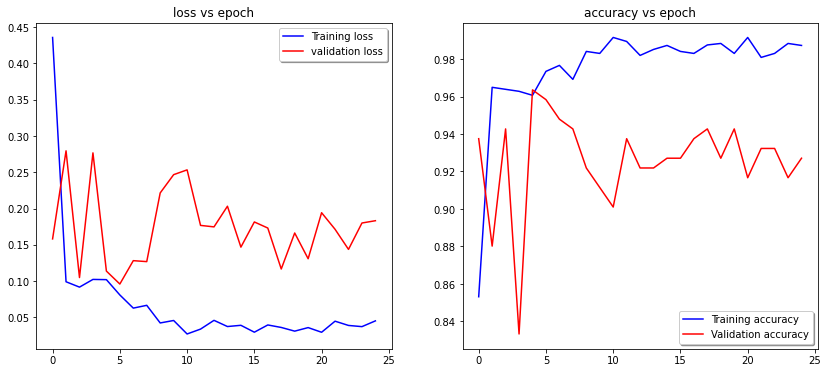

In [ ]:
plotLearningCurves(history) 

Podemos observar que a perda do modelo para o conjunto de treinamento cai rapidamente, atingindo um valor inferior a 10\% nas primeiras 3 épocas, aumenta sutilmente até a quinta época, e depois volta a cair para as épocas seguintes e se torna de certa forma constante. Para o conjunto de validação, a perda fica estável um pouco abaixo dos 20\% após a época 5, e não apresenta grande melhora até o fim do treinamento. A acurácia se comporta de forma semelhante, o conjunto de treino apresenta altos valores já nas primeiras épocas, se mantendo estável após a época 5, e o conjunto de validação apresenta acurácia um pouco acima dos 90\% após a época 5 e mantêm uma variação pequena até o fim.

In [ ]:
model.save("/mydrive/classificacao_de_imagens/saved_model/xception_imagenet.h5")
print("Saved model to disk")

Saved model to disk


In [12]:
!cp /mydrive/classificacao_de_imagens/saved_model/xception_imagenet.h5 ../

In [13]:
m1 = keras.models.load_model('xception_imagenet.h5')

### Imagens preditas

Aqui vemos algumas previsões sendo realizadas no conjunto de validação.

In [14]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(classes)

['n0', 'n1']


In [15]:
# checking model on validation data
def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our validation path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

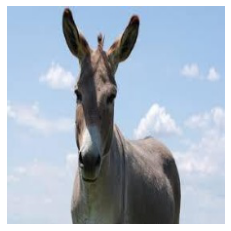

Predicted:  n0
True:  n0

---------------------------------------------------


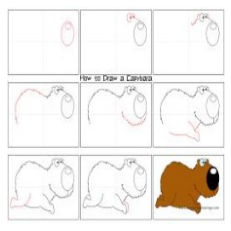

Predicted:  n1
True:  n1

---------------------------------------------------


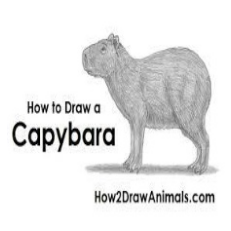

Predicted:  n1
True:  n1

---------------------------------------------------


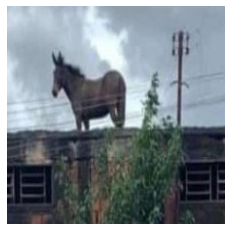

Predicted:  n0
True:  n0

---------------------------------------------------


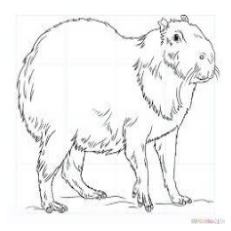

Predicted:  n1
True:  n1

---------------------------------------------------


In [16]:
# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 5):
    path = 'data/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m1.predict(images, batch_size = 10))
    predictions.append(classes)
    
for i in range(0, len(files)):
    img=mpimg.imread((files[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Predicted: ",class_labels[predictions[i]])
    print("True: ",true_labels[i])
    print("\n---------------------------------------------------")

### Matrix de confusão

Os valores da matriz de confusão mostram a capacidade do modelo detectar imagens da classe ``Equino'' com 89\% de precisão e imagens da classe ``Capivara'' com 85\% de precisão, além de ser capaz de detectar falsos positivos e falsos negativos de forma extremamente eficiente. Este modelo apresentou acurácia de 93\%, o que pode ser considerado alta, após poucas épocas de treinamento. A coluna ``Suporte'' indica o número de ocorrências de cada classe nos dados reais. O score $F1$ pode ser interpretado como a média harmônica entre a precisão e o recall, onde 1 é o melhor valor e 0 é o pior. A fórmula para o score $F1$ é $F1 = 2 * (precision * recall) / (precision + recall)$.

In [ ]:
# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 249):
    path = 'data/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m1.predict(images, batch_size = 10))
    predictions.append(classes)

In [ ]:
y_predict = predictions
y_valid = []
for i in range(0,len(true_labels)):
    if true_labels[i] == 'n0':
        y_valid.append(0)
    else:
        y_valid.append(1)

In [ ]:
print('testing report:', '\n', classification_report(y_valid, y_predict))
print('validation accuracy:', accuracy_score(y_valid, y_predict))

testing report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       136
           1       1.00      0.85      0.92       113

    accuracy                           0.93       249
   macro avg       0.94      0.92      0.93       249
weighted avg       0.94      0.93      0.93       249

validation accuracy: 0.9317269076305221


# Fine-tuning: Descongelando as primeiras camadas e fazendo mais algumas iterações


In [ ]:
# Atribuindo os pesos a uma variável
custom_weights = m1.load_weights("xception_imagenet.h5")

In [ ]:
img_rows, img_cols = 224, 224 

m1.trainable = True

m1.compile(optimizer=Adam(learning_rate = 1e-5),  # Very low learning rate
              loss='categorical_crossentropy',
               metrics = ['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
history_fine = m1.fit(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = 3,
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

Epoch 1/3
15/15 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.9415 
Epoch 1: val_loss improved from inf to 0.12378, saving model to trained_model/animals_xception_adam1.h5
15/15 [==============================] - 799s 52s/step - loss: 0.1427 - accuracy: 0.9415 - val_loss: 0.1238 - val_accuracy: 0.9479 - lr: 1.0000e-05
Epoch 2/3
15/15 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9604 
Epoch 2: val_loss did not improve from 0.12378
15/15 [==============================] - 799s 53s/step - loss: 0.1120 - accuracy: 0.9604 - val_loss: 0.1525 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 3/3
15/15 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9670 
Epoch 3: val_loss did not improve from 0.12378
15/15 [==============================] - 776s 52s/step - loss: 0.0995 - accuracy: 0.9670 - val_loss: 0.1899 - val_accuracy: 0.9219 - lr: 1.0000e-05


In [ ]:
np.save('history_fine.npy',history_fine.history)

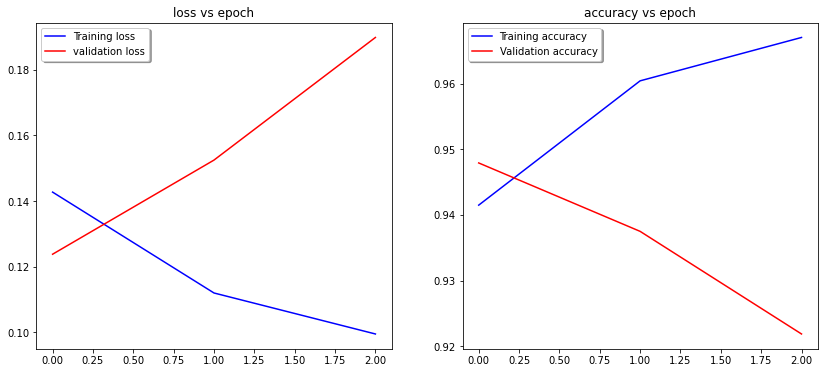

In [ ]:
plotLearningCurves(history_fine) 

In [ ]:
# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 249):
    path = 'data/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m1.predict(images, batch_size = 10))
    predictions.append(classes)

In [ ]:
y_predict = predictions
y_valid = []
for i in range(0,len(true_labels)):
    if true_labels[i] == 'n0':
        y_valid.append(0)
    else:
        y_valid.append(1)

In [ ]:
print('testing report:', '\n', classification_report(y_valid, y_predict))
print('validation accuracy:', accuracy_score(y_valid, y_predict))

testing report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       130
           1       1.00      0.89      0.94       119

    accuracy                           0.95       249
   macro avg       0.95      0.95      0.95       249
weighted avg       0.95      0.95      0.95       249

validation accuracy: 0.9477911646586346


# Segundo Modelo

O segundo modelo, assim com o primeiro, também utilizou a arquitetura Xception, porém sem os pesos pré-treinados no ImageNet. As camadas superiores são compostas pela mesma estrutura MLP apresentada no modelo anterior: uma camada de GlobalAveragePooling2D, seguida por duas camadas densas com 1024 nêurons com função de ativação ReLU, uma camada densa com 512 nêurons também com camada de ativação ReLU, e uma camada de saída com 2 nêurons e função de ativação softmax.\\

## Xception sem os pesos do imagenet

In [ ]:
img_rows, img_cols = 224, 224 
    
# Sem os pesos do imagenet (random initialization)
xception_2 = tf.keras.applications.Xception(weights = None, include_top = False, input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
#for layer in xception_2.layers:
#    layer.trainable = False
    
for (i,layer) in enumerate(xception_2.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

## Juntando o modelo base com o topo

In [ ]:
FC_Head_2 = addTopModelXception(xception_2)
model_2 = Model(inputs = xception_2.input, outputs = FC_Head_2)
print(model_2.summary())

In [ ]:
train_data_dir = 'data/training/'
validation_data_dir = 'data/validation/'

train_datagen = ImageDataGenerator(rescale=1./255.0, rotation_range=45, width_shift_range=0.3, height_shift_range=0.3,
                                   horizontal_flip=True, fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255.0)

In [ ]:
checkpoint = ModelCheckpoint("trained_model/animals_xception_adam1_no_weight.h5", monitor="val_loss", mode="min", 
                             save_best_only = True, verbose=1)

#earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [checkpoint, reduce_lr] #[earlystop, checkpoint, reduce_lr] 

model_2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

## Treinando o modelo

In [ ]:
history_2 = model_2.fit(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs,
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

In [ ]:
model_2.save("/mydrive/classificacao_de_imagens/saved_model/xception_no_imagenet2.h5")

In [ ]:
np.save('/mydrive/classificacao_de_imagens/saved_model/history_2',history_2.history)

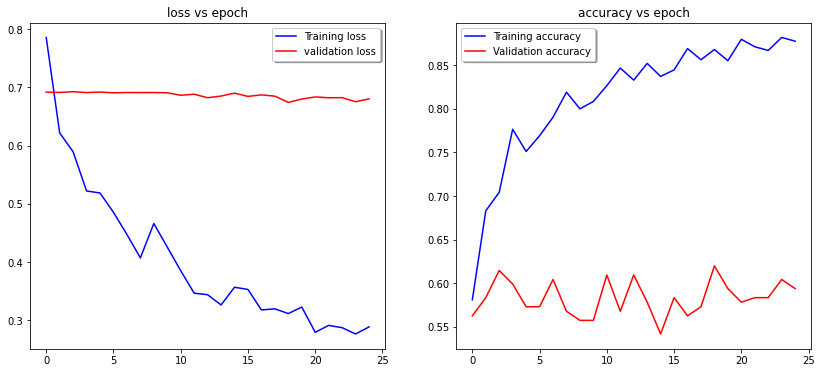

In [ ]:
plotLearningCurves(history_2)

O gráfico de perda por época mostra que, ao final das 25 épocas, apenas o conjunto de treinamento apresentou uma redução significativa, enquanto o conjunto de validação permaneceu aproximadamente constante em 70\%. O comportamento da acurácia é semelhante, apresentando melhora significativa apenas no conjunto de treinamento, atingindo valores superiores a 85\%. O conjunto de validação parece variar em torno de 55\%. O comportamento das curvas parece indicar que há um sobreajuste no treinamento do modelo. Isso provavelmente está ocorrendo devido ao pequeno número de amostras de treino, sobretudo levando em consideração o elevado grau de complexidade do modelo Xception, que provavelmente demanda um alto número de imagens de treino para evitar sobreajuste. 

## Matriz de confusão

In [ ]:
m2 = keras.models.load_model('/mydrive/classificacao_de_imagens/saved_model/xception_no_imagenet2.h5')

In [ ]:
# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 249):
    path = 'data/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m2.predict(images, batch_size = 10))
    predictions.append(classes)

In [ ]:
y_predict = predictions
y_valid = []
for i in range(0,len(true_labels)):
    if true_labels[i] == 'n0':
        y_valid.append(0)
    else:
        y_valid.append(1)

In [ ]:
print('testing report:', '\n', classification_report(y_valid, y_predict))
print('validation accuracy:', accuracy_score(y_valid, y_predict))

testing report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.51      1.00      0.67       126

    accuracy                           0.51       249
   macro avg       0.25      0.50      0.34       249
weighted avg       0.26      0.51      0.34       249

validation accuracy: 0.5060240963855421


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aparentemente, esse modelo não é capaz de detectar a classe "Equino", e mesmo a classe "Capivara" aparece com precisão baixa. Esse modelo tem acurácia total de 51\%. Modelos com valores de acurácia próximos ou inferiores a 50\% não podem ser considerados úteis, uma vez que ter 50\% de acurácia indica que não há diferença entre selecionar o modelo e fazer um sorteio aleatório.

# Terceiro Modelo

O terceiro modelo é simplesmente um MLP sem camadas convolucionais. Ele possui a mesma estrutura das camadas superiores dos modelos anteriores: duas camadas densas com 1024 nêurons com função de ativação ReLU, uma camada densa com 512 nêurons também com camada de ativação ReLU, e uma camada de saída com 2 nêurons e função de ativação softmax.

In [ ]:
inputs = keras.Input(shape=(img_rows, img_cols, 3))

model_no_transfer = GlobalAveragePooling2D()(inputs)
model_no_transfer = Dense(1024,activation='relu')(model_no_transfer)
model_no_transfer = Dense(1024,activation='relu')(model_no_transfer)
model_no_transfer = Dense(512,activation='relu')(model_no_transfer)
outputs = Dense(2, activation='softmax')(model_no_transfer)

model_no_transfer_2 = keras.Model(inputs, outputs)

model_no_transfer_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 global_average_pooling2d_1   (None, 3)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              4096      
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                           

In [ ]:
model_no_transfer_2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [ ]:
history_3 = model_no_transfer_2.fit(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs,
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

In [ ]:
model_no_transfer_2.save("C:/Users/malta/Desktop/Pós Graduação/Trabalho_final_Pos/Reunião 3/Trabalho final/trained_model/xception_no_transfer.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
np.save('history_3.npy',history_3.history)

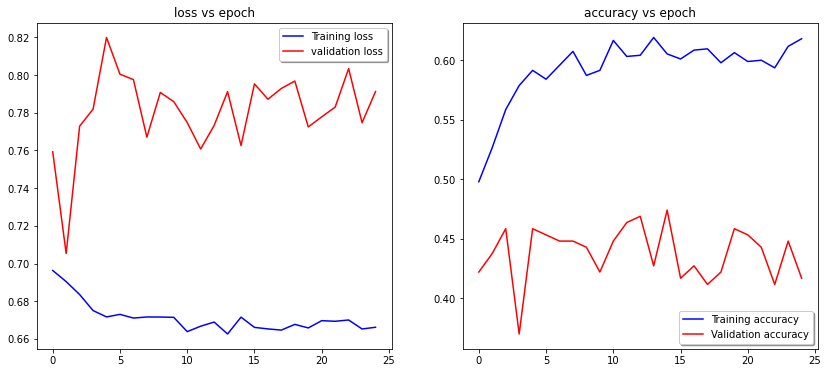

In [ ]:
plotLearningCurves(history_3)

Neste caso, pode-se ver a perda no conjunto de treino tende a se estabilizar em um alto valor próximo a 67\%, enquanto o conjunto de validação apresenta perdas próximas de 80\%. A acurácia de treinamento se estabiliza em torno dos 60\%, enquanto a de validação fica consistentemente abaixo dos 50\%, próxima dos 45\%.

## Matriz de confusão

In [ ]:
m3 = keras.models.load_model('trained_model/xception_no_transfer.h5')

In [ ]:
# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 249):
    path = 'validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m3.predict(images, batch_size = 10))
    predictions.append(classes)

In [ ]:
y_predict = predictions
y_valid = []
for i in range(0,len(true_labels)):
    if true_labels[i] == 'n0':
        y_valid.append(0)
    else:
        y_valid.append(1)

In [ ]:
print('testing report:', '\n', classification_report(y_valid, y_predict))
print('validation accuracy:', accuracy_score(y_valid, y_predict))

testing report: 
               precision    recall  f1-score   support

           0       0.47      0.46      0.46       140
           1       0.33      0.34      0.33       109

    accuracy                           0.41       249
   macro avg       0.40      0.40      0.40       249
weighted avg       0.41      0.41      0.41       249

validation accuracy: 0.40562248995983935


A matriz de confusão apresenta valores inferiores a 50\% para a detecção de ambas as classes, indicando que esse modelo não é ideal para esse tipo de análise. A acurácia total do modelo foi de 41\%, indicando que é pior do que escolher aleatoriamente a classe da imagem de entrada.

# Resultados

O terceiro modelo foi o que performou pior entre todos, apresentado apenas 40\% de acurácia. Esse caso serve para ilustrar a necessidade da inclusão de camadas convolucionais para o processo de classificação de imagens, onde as camadas MLP não se monstram suficiente em reconhecer os padrões.

O segundo modelo também não foi capaz de performar bem. Os gráficos mostram que houve um sobreajuste no modelo, uma vez que não há redução na perda, nem melhora na acurácia, para o conjunto de validação, enquanto o conjunto de treino progride com o passar das épocas. Além disso, o modelo só foi capaz de detectar uma das classes ao final do período de treinamento. Talvez fosse necessária uma base de dados maior e um número maior de épocas para que esse tipo de modelo fosse capaz de obter bons resultados. Entre todos os três modelos esse foi o que demandou o maior tempo para treinamento, levando mais de 5 vezes o tempo necessário para rodar o modelo com transfer learning, pela mesma quantidade de épocas.

O primeiro modelo apresentou resultados superiores e seu custo computacional foi inferior ao segundo modelo (treinado do zero). Foi observado 90\% de acurácia de validação e valores acima 80\% para precisão e recall para o modelo base. Após a etapa de fine-tuning, os valores apresentaram uma melhora considerável de 4\%, atingindo uma acurácia final de 94\%. Percebe-se que a utilização do transfer learning de fato implica em maior eficiência computacional e melhores resultados preditivos.